# draft

## import

In [200]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time 

## Define some funtions

In [201]:
def f(txt,mapping):
    return [mapping[key] for key in txt] 
soft = torch.nn.Softmax(dim=1)

## Exam4: AbAcAd

### data

`-` 기존의 정리방식

In [202]:
txt = list('AbAcAd')*100
txt[:10]

['A', 'b', 'A', 'c', 'A', 'd', 'A', 'b', 'A', 'c']

In [203]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [204]:
txt_x[:5],txt_y[:5]

(['A', 'b', 'A', 'c', 'A'], ['b', 'A', 'c', 'A', 'd'])

In [205]:
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,{'A':0,'b':1,'c':2,'d':3}))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,{'A':0,'b':1,'c':2,'d':3}))).float()

In [206]:
x,y

(tensor([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.]]),
 tensor([[0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.]]))

### 순환신경망 구현2 (with RNNCell, hidden node 2) -- 성공 

ref: https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html

`(1)` 숙성네트워크

In [207]:
torch.manual_seed(43052)
rnncell = torch.nn.RNNCell(4,2)

`(2)` 조리네트워크

In [208]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) # 조리담당

`(3)` 손실함수와 옵티마이저 

In [209]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters())) # 우리가 배울것: 숙성하는 방법 + 요리하는 방법 

`(4)` 학습

In [210]:
T = len(x)
t1 = time.time()
for epoc in range(5000):
    ## 1~2
    loss = 0 
    ht = torch.zeros(1,2)
    for t in range(T):
        xt, yt = x[[t]], y[[t]]       
        ht = rnncell(xt,ht) 
        ot = cook(ht)
        loss = loss + loss_fn(ot,yt) 
    loss = loss/T 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time() 
t2-t1

310.1117684841156

`(5)` 시각화 

In [211]:
T = len(x) 
hidden = torch.zeros(T,2) # 599년치 h를 담을 변수 
_water = torch.zeros(1,2) # 맹물 
hidden[[0]] = rnncell(x[[0]],_water) 
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])

In [212]:
yhat = soft(cook(hidden))
yhat 

tensor([[1.9725e-02, 1.5469e-03, 8.2766e-01, 1.5106e-01],
        [9.1875e-01, 1.6513e-04, 6.7703e-02, 1.3384e-02],
        [2.0031e-02, 1.0659e-03, 8.5248e-01, 1.2642e-01],
        ...,
        [1.9640e-02, 1.3568e-03, 8.3705e-01, 1.4196e-01],
        [9.9564e-01, 1.3114e-05, 3.5069e-03, 8.4108e-04],
        [3.5473e-03, 1.5670e-01, 1.4102e-01, 6.9873e-01]],
       grad_fn=<SoftmaxBackward0>)

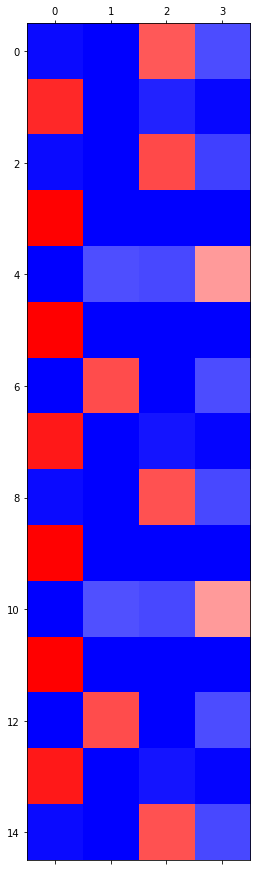

In [213]:
plt.matshow(yhat.data[:15],cmap='bwr')

- 앞부분은 틀린것도 있네? ㅎㅎ

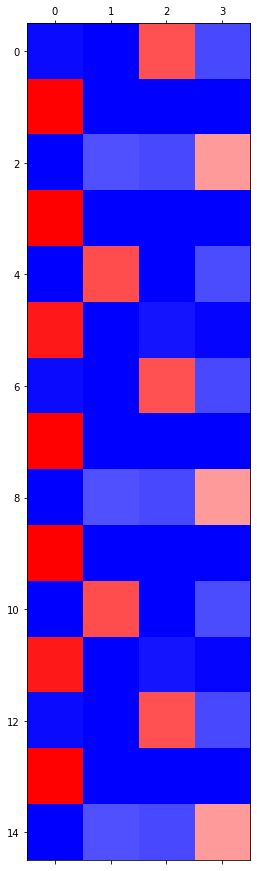

In [214]:
plt.matshow(yhat.data[-15:],cmap='bwr')

- 뒷부분은 거의 다 맞춤 

### 순환신경망 구현3 (with RNN, hidden node 2) -- 성공 

(예비학습)

`-` 아무리 생각해도 yhat구하려면 좀 귀찮음

In [215]:
T = len(x) 
hidden = torch.zeros(T,2) # 599년치 h를 담을 변수 
_water = torch.zeros(1,2) # 맹물 
hidden[[0]] = rnncell(x[[0]],_water) 
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])

In [216]:
soft(cook(hidden))

tensor([[1.9725e-02, 1.5469e-03, 8.2766e-01, 1.5106e-01],
        [9.1875e-01, 1.6513e-04, 6.7703e-02, 1.3384e-02],
        [2.0031e-02, 1.0659e-03, 8.5248e-01, 1.2642e-01],
        ...,
        [1.9640e-02, 1.3568e-03, 8.3705e-01, 1.4196e-01],
        [9.9564e-01, 1.3114e-05, 3.5069e-03, 8.4108e-04],
        [3.5473e-03, 1.5670e-01, 1.4102e-01, 6.9873e-01]],
       grad_fn=<SoftmaxBackward0>)

`-` 이렇게 하면 쉽게(?) 구할 수 있음 

In [217]:
rnn = torch.nn.RNN(4,2) 

In [218]:
rnn.weight_hh_l0.data = rnncell.weight_hh.data 
rnn.bias_hh_l0.data = rnncell.bias_hh.data 
rnn.weight_ih_l0.data = rnncell.weight_ih.data 
rnn.bias_ih_l0.data = rnncell.bias_ih.data 

In [219]:
_water

tensor([[0., 0.]])

In [220]:
soft(cook(rnn(x,_water)[0]))

tensor([[1.9725e-02, 1.5469e-03, 8.2766e-01, 1.5106e-01],
        [9.1875e-01, 1.6513e-04, 6.7703e-02, 1.3384e-02],
        [2.0031e-02, 1.0659e-03, 8.5248e-01, 1.2642e-01],
        ...,
        [1.9640e-02, 1.3568e-03, 8.3705e-01, 1.4196e-01],
        [9.9564e-01, 1.3114e-05, 3.5069e-03, 8.4108e-04],
        [3.5473e-03, 1.5670e-01, 1.4102e-01, 6.9873e-01]],
       grad_fn=<SoftmaxBackward0>)

- 똑같음!

`-` rnn(x,_water)의 결과는 (1) 599년치 간장 (2) 599번째 간장 이다 

In [221]:
rnn(x,_water)

(tensor([[-0.9912, -0.9117],
         [ 0.0698, -1.0000],
         [-0.9927, -0.9682],
         ...,
         [-0.9935, -0.9315],
         [ 0.5777, -1.0000],
         [-0.9960, -0.0109]], grad_fn=<SqueezeBackward1>),
 tensor([[-0.9960, -0.0109]], grad_fn=<SqueezeBackward1>))

***(예비학습결론) torch.nn.RNN(4,2)는 torch.nn.RNNCell(4,2)의 batch 버전이다. (for문이 포함된 버전이다)***

---

torch.nn.RNN(4,2)를 이용하여 구현하자. 

`(1)` 숙성네트워크

선언

In [222]:
rnn = torch.nn.RNN(4,2)

가중치초기화

In [223]:
torch.manual_seed(43052)
rnncell = torch.nn.RNNCell(4,2) 

In [224]:
rnn.weight_ih_l0.data = rnncell.weight_ih.data
rnn.bias_ih_l0.data = rnncell.bias_ih.data
rnn.weight_hh_l0.data = rnncell.weight_hh.data
rnn.bias_hh_l0.data = rnncell.bias_hh.data

`(2)` 조리네트워크

In [225]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4)

`(3)` 손실함수와 옵티마이저

In [226]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters())) # 우리가 배울것: 숙성하는 방법 + 요리하는 방법 

`(4)` 학습

In [227]:
t1 = time.time()
for epoc in range(5000):
    ## 1
    _water = torch.zeros(1,2)
    hidden, hT = rnn(x,_water)
    output = cook(hidden)
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time() 
t2-t1

64.92704916000366

`(5)` 시각화

In [228]:
yhat = soft(cook(rnn(x,_water)[0]))
yhat

tensor([[1.9725e-02, 1.5469e-03, 8.2766e-01, 1.5106e-01],
        [9.1875e-01, 1.6513e-04, 6.7703e-02, 1.3384e-02],
        [2.0031e-02, 1.0659e-03, 8.5248e-01, 1.2642e-01],
        ...,
        [1.9640e-02, 1.3568e-03, 8.3705e-01, 1.4196e-01],
        [9.9564e-01, 1.3114e-05, 3.5069e-03, 8.4108e-04],
        [3.5473e-03, 1.5670e-01, 1.4102e-01, 6.9873e-01]],
       grad_fn=<SoftmaxBackward0>)

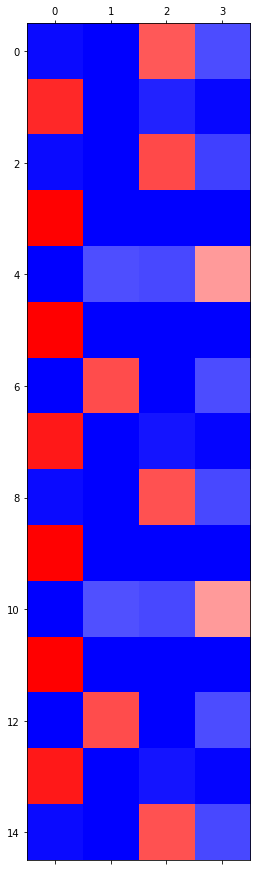

In [229]:
plt.matshow(yhat.data[:15],cmap='bwr')

In [230]:
combinded = torch.concat([hidden, yhat],axis=1)
combinded

tensor([[-9.9117e-01, -9.1171e-01,  1.9725e-02,  1.5469e-03,  8.2766e-01,
          1.5106e-01],
        [ 6.9670e-02, -1.0000e+00,  9.1875e-01,  1.6513e-04,  6.7703e-02,
          1.3384e-02],
        [-9.9266e-01, -9.6819e-01,  2.0031e-02,  1.0659e-03,  8.5248e-01,
          1.2642e-01],
        ...,
        [-9.9346e-01, -9.3147e-01,  1.9640e-02,  1.3568e-03,  8.3705e-01,
          1.4196e-01],
        [ 5.7768e-01, -1.0000e+00,  9.9564e-01,  1.3114e-05,  3.5069e-03,
          8.4108e-04],
        [-9.9599e-01, -1.0866e-02,  3.5473e-03,  1.5670e-01,  1.4102e-01,
          6.9873e-01]], grad_fn=<CatBackward0>)

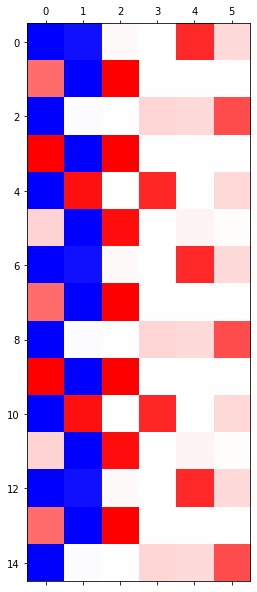

In [231]:
plt.matshow(combinded[-15:].data,cmap='bwr')

### 순환신경망 구현4 (with RNN, hidden node 3) -- 성공 

`(1)` 숙성네트워크

In [232]:
rnn = torch.nn.RNN(4,3)

`(2)` 조리네트워크

In [233]:
torch.manual_seed(43052)
cook = torch.nn.Linear(3,4)

`(3)` 손실함수와 옵티마이저

In [234]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters())) # 우리가 배울것: 숙성하는 방법 + 요리하는 방법 

`(4)` 학습

In [235]:
t1 = time.time()
for epoc in range(5000):
    ## 1
    _water = torch.zeros(1,3)
    hidden, hT = rnn(x,_water)
    output = cook(hidden)
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time() 
t2-t1

64.3333568572998

`(5)` 시각화

In [236]:
yhat = soft(cook(rnn(x,_water)[0]))
yhat

tensor([[1.2133e-02, 7.2523e-01, 5.6946e-03, 2.5694e-01],
        [9.9925e-01, 6.9948e-04, 1.2285e-05, 4.1846e-05],
        [3.7845e-05, 1.4367e-03, 8.3668e-01, 1.6184e-01],
        ...,
        [3.7551e-05, 1.4242e-03, 8.3732e-01, 1.6122e-01],
        [9.9755e-01, 2.0414e-03, 6.3133e-05, 3.4456e-04],
        [1.9711e-03, 1.5161e-01, 1.6135e-01, 6.8506e-01]],
       grad_fn=<SoftmaxBackward0>)

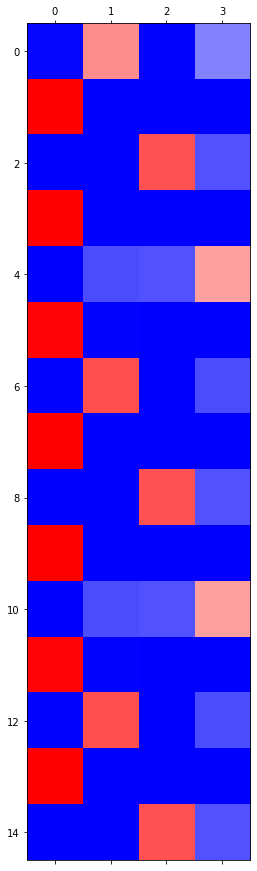

In [237]:
plt.matshow(yhat.data[:15],cmap='bwr')

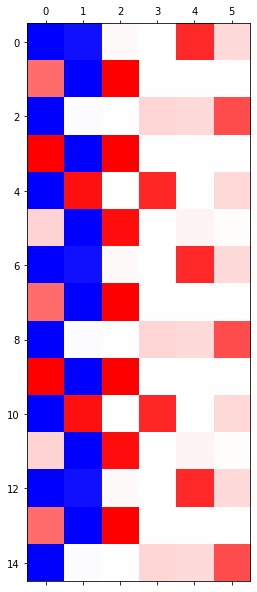

In [238]:
plt.matshow(combinded[-15:].data,cmap='bwr')

## Exam5: hello

### data

`-` 기존의 정리방식

In [244]:
txt = list('hello')*100
txt[:10]

['h', 'e', 'l', 'l', 'o', 'h', 'e', 'l', 'l', 'o']

In [245]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [248]:
txt_x[:5],txt_y[:5]

(['h', 'e', 'l', 'l', 'o'], ['e', 'l', 'l', 'o', 'h'])

In [249]:
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,{'h':0,'e':1,'l':2,'o':3}))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,{'h':0,'e':1,'l':2,'o':3}))).float()

In [250]:
x,y

(tensor([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.]]),
 tensor([[0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]))

### 순환신경망 구현 (hidden node 3)

In [252]:
rnn = torch.nn.RNN(4,3)
cook = torch.nn.Linear(3,4) 
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()))

In [254]:
for epoc in range(5000):
    ## 1
    _water = torch.zeros(1,3)
    hidden, hT = rnn(x,_water)
    output = cook(hidden)
    ## 2
    loss = loss_fn(output,y) 
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [265]:
combinded = torch.concat([hidden,soft(output)],axis=1)

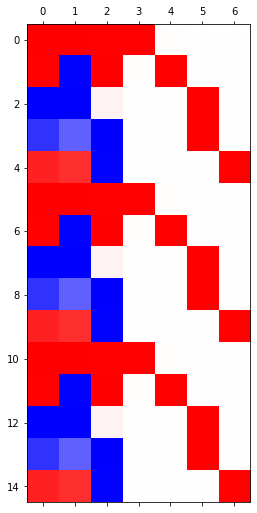

In [267]:
plt.matshow(combinded[-15:].detach().numpy(),cmap='bwr')

`-` hidden layer의 해석 

- o -> rrr -> h
- h -> rbr -> e 
- e -> bbw -> l 
- l -> bbb -> l
- l -> rrb -> o 

`-` 오히려 el을 비슷하게 생각함. (e/l 모두 출력으로 l을 가지므로 공통점이 있다고 생각함) 